<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/%08w4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [4주차] 기본과제: HuggingFace로 두 문장의 논리적 모순 분류하기

이번 과제는 자연어 task 중 하나인 MNLI를 해결하는 모델을 HuggingFace로 학습하는 것입니다. MNLI를 요약하면 다음과 같습니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

- 학습 때는 `train` split만 활용하셔야 합니다. 나머지 split은 사용불가입니다.
- Validation data가 필요한 경우, `train` split에서 가져오셔야 합니다.
- `trainer.train()`를 통해 학습된 log가 남아있어야 합니다.
- Dataset의 `validation_matched`에 대한 성능을 출력하고, 50%를 넘기셔야 합니다.

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset 준비

In [4]:
ds = load_dataset("nyu-mll/glue", "mnli")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
ds['train'][0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

## [MY CODE] EDA

max_len 값 설정을 위해 데이터셋에서 premise와 hypothesis를 한 문장으로 합친 길이를 구합니다.

학습 데이터:
- 최대 길이: 396
- 평균 길이: 29.78

검증 데이터 (matched):
- 최대 길이: 216
- 평균 길이: 29.18


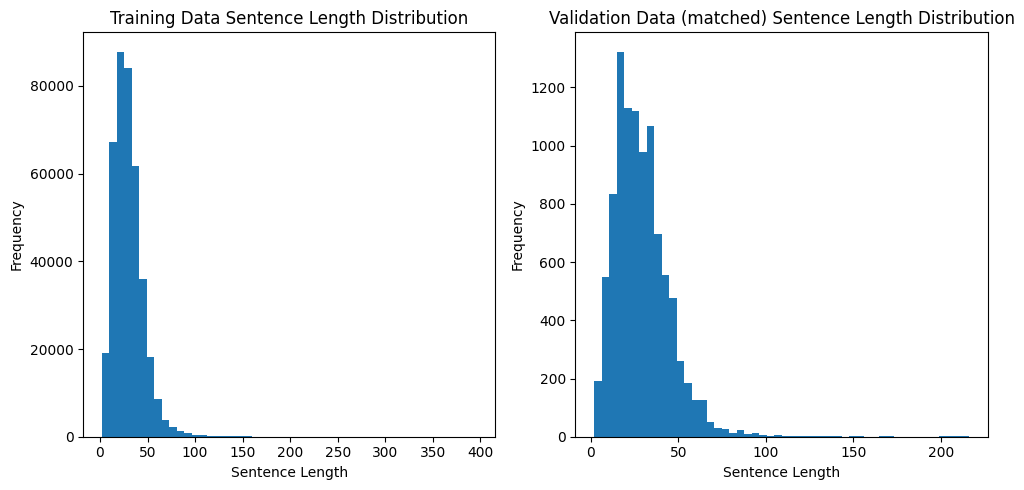

In [5]:
import matplotlib.pyplot as plt
from statistics import mean

# 각 데이터셋의 문장 길이 계산
train_lengths = [len(p.split() + h.split()) for p, h in zip(ds['train']['premise'], ds['train']['hypothesis'])]
val_matched_lengths = [len(p.split() + h.split()) for p, h in zip(ds['validation_matched']['premise'], ds['validation_matched']['hypothesis'])]


# 통계 계산
print(f"학습 데이터:")
print(f"- 최대 길이: {max(train_lengths)}")
print(f"- 평균 길이: {mean(train_lengths):.2f}")
print(f"\n검증 데이터 (matched):")
print(f"- 최대 길이: {max(val_matched_lengths)}")
print(f"- 평균 길이: {mean(val_matched_lengths):.2f}")

# 히스토그램 그리기
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=50)
plt.title('Training Data Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(val_matched_lengths, bins=50)
plt.title('Validation Data (matched) Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## [LOG] 대부분 100자 이하기 때문에 max length를 128자로 두고, 128자 이상인 데이터를 제외하고 학습

In [6]:
import datasets

# 학습 데이터만 필터링하고 나머지는 그대로 유지
filtered_train = ds['train'].filter(lambda x: len(x['premise'].split()) + len(x['hypothesis'].split()) < 128)

# 필터링된 학습 데이터와 기존 검증/테스트 데이터를 새로운 DatasetDict으로 결합
ds = datasets.DatasetDict({
    'train': filtered_train,
    'validation_matched': ds['validation_matched'],
    'validation_mismatched': ds['validation_mismatched'],
    'test_matched': ds['test_matched'],
    'test_mismatched': ds['test_mismatched']
})

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

학습 데이터:
- 최대 길이: 127
- 평균 길이: 29.56

검증 데이터 (matched):
- 최대 길이: 216
- 평균 길이: 29.18


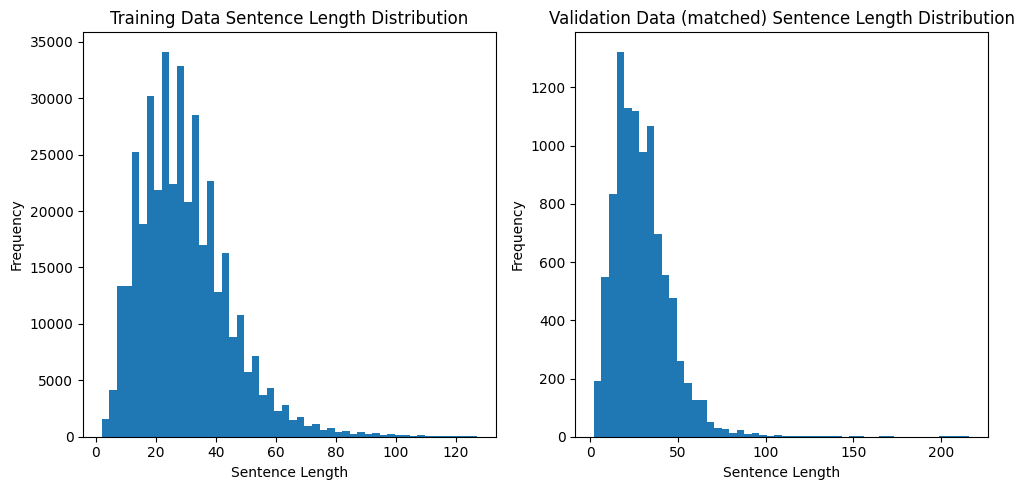

In [14]:
import matplotlib.pyplot as plt
from statistics import mean

# 각 데이터셋의 문장 길이 계산
train_lengths = [len(p.split() + h.split()) for p, h in zip(sliced_ds['train']['premise'], sliced_ds['train']['hypothesis'])]
val_matched_lengths = [len(p.split() + h.split()) for p, h in zip(ds['validation_matched']['premise'], ds['validation_matched']['hypothesis'])]


# 통계 계산
print(f"학습 데이터:")
print(f"- 최대 길이: {max(train_lengths)}")
print(f"- 평균 길이: {mean(train_lengths):.2f}")
print(f"\n검증 데이터 (matched):")
print(f"- 최대 길이: {max(val_matched_lengths)}")
print(f"- 평균 길이: {mean(val_matched_lengths):.2f}")

# 히스토그램 그리기
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=50)
plt.title('Training Data Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(val_matched_lengths, bins=50)
plt.title('Validation Data (matched) Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## [LOG] 학습데이터는 128자 미만, 테스트 데이터는 원본 그대로 유지

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(
        data["premise"],
        data["hypothesis"],
        truncation=True,
        padding=True,
        max_length=128,
    )

tokenized_ds = ds.map(preprocess_function, batched=True)
tokenized_ds

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/392052 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392052
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [16]:
tokenized_ds['train'][0].keys()

dict_keys(['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'])

## [MY CODE] train과 validation 셋 구분

8:2로 train셋을 나누어서 validation에 사용

In [17]:
ds_split = tokenized_ds['train'].train_test_split(test_size=0.2)
ds_train, ds_val = ds_split['train'], ds_split['test']
ds_test = tokenized_ds['validation_matched']

HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.

In [18]:
len(ds_train), len(ds_val), len(ds_test)

(313641, 78411, 9815)

## [MY CODE] Model 구현

bert-base-cased를 이용하여 fine-tuning을 진행합니다

In [19]:
id2label = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
label2id = {"Entailment": 0, "Neutral": 1, "Contradiction": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", num_labels=3, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [MY CODE] 학습 코드



In [20]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="mnli_classifier",
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    evaluation_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=500
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-22-7a1a029440b4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.553400,0.462073,0.818635
2,0.376100,0.441790,0.831019
3,0.265600,0.484720,0.831618
4,0.186600,0.561473,0.828825
5,0.133300,0.650474,0.826249
6,0.098100,0.735423,0.827205
7,0.074500,0.853703,0.824680
8,0.057800,0.892868,0.826950
9,0.045900,1.023744,0.826950
10,0.037200,1.082273,0.827142


TrainOutput(global_step=49010, training_loss=0.1828713342915309, metrics={'train_runtime': 30904.1235, 'train_samples_per_second': 101.488, 'train_steps_per_second': 1.586, 'total_flos': 2.0630788862406912e+17, 'train_loss': 0.1828713342915309, 'epoch': 10.0})

## [LOG] validation loss는 3 epoch부터 증가 -> 과적합


위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
test_results = trainer.evaluate(ds_test)
test_results

{'eval_loss': 0.3246372938156128,
 'eval_accuracy': 0.86464,
 'eval_runtime': 25.3668,
 'eval_samples_per_second': 985.54,
 'eval_steps_per_second': 7.727,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/models"

trainer.save_model(save_path)

## [MY CODE] 새 모델 학습

기존 학습의 모델을 저장하지 못하고 Runtime이 종료되면서 다시 학습이 필요해졌습니다.
bert가 아닌 distilbert를 사용해서 학습시간을 줄여보려고 합니다.

In [8]:
id2label = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
label2id = {"Entailment": 0, "Neutral": 1, "Contradiction": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


보시다시피 `distilbert`는 기존의 distilbert 모델에 해당하고 나머지 `pre_classifier`, `classifier`는 text 분류를 위해 새롭게 추가된 layer들입니다.
즉, 다음과 같이 `distilbert`에 해당하는 parameter들만 freeze하면 됩니다.

In [10]:
for param in model.distilbert.parameters():
  param.requires_grad = False

## [MY CODE] 학습데이터 경량화

학습데이터도 기존 8:2로 validation을 나누던 것을
7:3으로 나누어서 학습시간을 조금 더 줄여보고자 합니다.

In [11]:
ds_split = tokenized_ds['train'].train_test_split(test_size=0.3)
ds_train, ds_val = ds_split['train'], ds_split['test']
ds_test = tokenized_ds['validation_matched']
len(ds_train), len(ds_val), len(ds_test)

(274436, 117616, 9815)

## [MY CODE] epoch축소

이번에도 과적합이 발생할 것으로 예상되어 기존의 절반인 5epoch로 진행

In [12]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir="mnli_classifier",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    evaluation_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=500
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-14-7a1a029440b4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,1.088900,1.078951,0.408031
2,1.078700,1.071682,0.417248
3,1.075000,1.068300,0.422409
4,1.073000,1.066694,0.424908
5,1.072000,1.066206,0.426490


TrainOutput(global_step=21445, training_loss=1.0775259247857891, metrics={'train_runtime': 3484.4225, 'train_samples_per_second': 393.804, 'train_steps_per_second': 6.155, 'total_flos': 4.544308917047808e+16, 'train_loss': 1.0775259247857891, 'epoch': 5.0})

In [16]:
save_path = "/content/drive/My Drive/Colab Notebooks/models"

trainer.save_model(save_path)

학습한 모델에 대한 결과는 다음과 같습니다.

In [17]:
test_results = trainer.evaluate(ds_test)
test_results

{'eval_loss': 1.0681017637252808,
 'eval_accuracy': 0.4214977075904228,
 'eval_runtime': 16.8442,
 'eval_samples_per_second': 582.693,
 'eval_steps_per_second': 9.143,
 'epoch': 5.0}

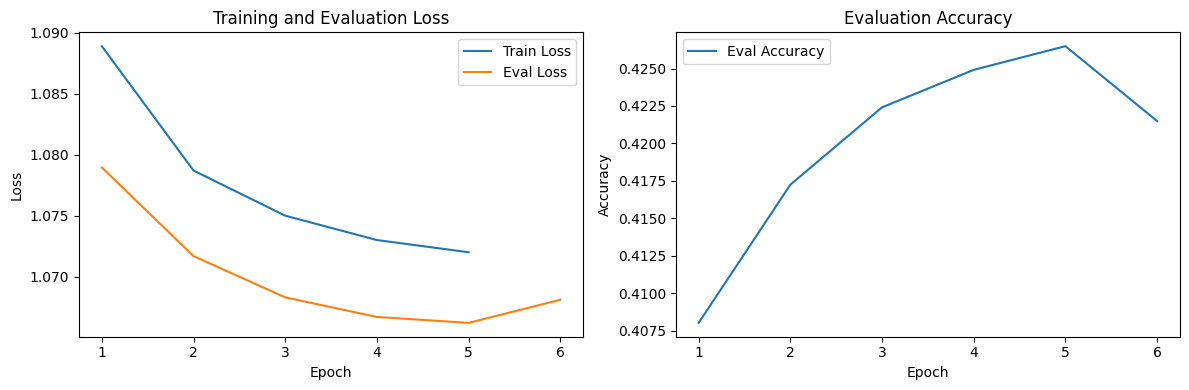

In [21]:
import matplotlib.pyplot as plt

# loss 값 추출
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# accuracy 값 추출
eval_accuracy = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]


# epoch 값 추출 (eval_loss를 기준으로)
epochs = range(1, len(eval_loss) + 1)

# Loss 그래프 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정

plt.subplot(1, 2, 1)  # 1x2 그리드의 첫 번째 subplot
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

# Accuracy 그래프 그리기
plt.subplot(1, 2, 2)  # 1x2 그리드의 두 번째 subplot
plt.plot(epochs, eval_accuracy, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.tight_layout()  # subplot 간 간격 조정
plt.show()

## [MY CODE] 정확도가 높지 않아서 distilbert도 학습


bert를 그대로 사용했을 때는 80%가 넘게 나왔는데, distilbert로 학습하니 50%가 나오지 않음. 단순히 pretrained모델의 차이인지, pretrained모델을 학습에서 배제해서 인지 확인 하기 위해 distilbert도 학습이 되도록 수정

In [22]:
for param in model.distilbert.parameters():
  param.requires_grad = True

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-23-7a1a029440b4>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.886300,0.806939,0.640874
2,0.768100,0.768995,0.666916
3,0.699400,0.752836,0.675359
4,0.642700,0.776968,0.674662
5,0.600300,0.785430,0.675512


TrainOutput(global_step=21445, training_loss=0.7193739617335043, metrics={'train_runtime': 7237.2949, 'train_samples_per_second': 189.598, 'train_steps_per_second': 2.963, 'total_flos': 4.544308917047808e+16, 'train_loss': 0.7193739617335043, 'epoch': 5.0})

In [25]:
save_path = "/content/drive/My Drive/Colab Notebooks/models"

trainer.save_model(save_path)

In [26]:
test_results = trainer.evaluate(ds_test)
test_results

{'eval_loss': 0.7919292449951172,
 'eval_accuracy': 0.6751910341314314,
 'eval_runtime': 16.7976,
 'eval_samples_per_second': 584.309,
 'eval_steps_per_second': 9.168,
 'epoch': 5.0}

## [LOG] 정확도 67.5%

distilbert도 함께 학습해야 정확도가 잘 올라감

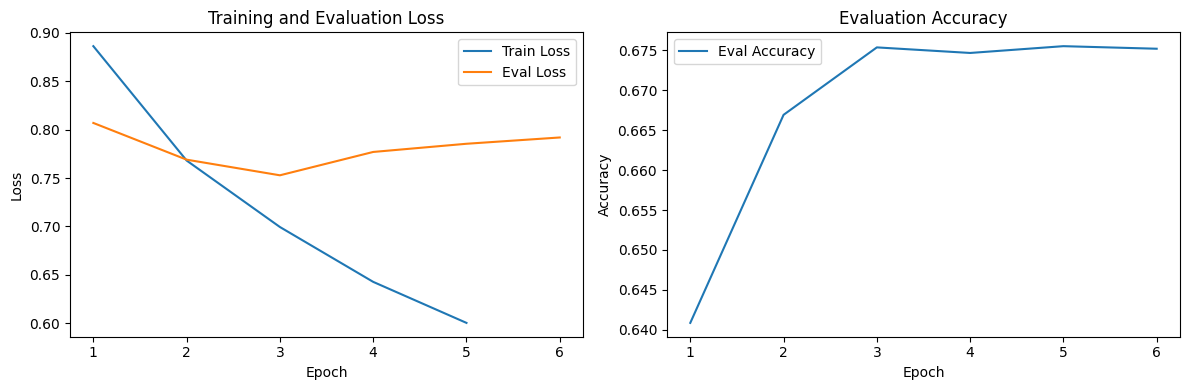

In [27]:
import matplotlib.pyplot as plt

# loss 값 추출
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# accuracy 값 추출
eval_accuracy = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]


# epoch 값 추출 (eval_loss를 기준으로)
epochs = range(1, len(eval_loss) + 1)

# Loss 그래프 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정

plt.subplot(1, 2, 1)  # 1x2 그리드의 첫 번째 subplot
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

# Accuracy 그래프 그리기
plt.subplot(1, 2, 2)  # 1x2 그리드의 두 번째 subplot
plt.plot(epochs, eval_accuracy, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.tight_layout()  # subplot 간 간격 조정
plt.show()

## [LOG] 3epoch 이후로는 정확도가 개선되지 않음

In [28]:
trainer.state.log_history

[{'loss': 0.8863,
  'grad_norm': 14.24431037902832,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 1.0,
  'step': 4289},
 {'eval_loss': 0.8069390058517456,
  'eval_accuracy': 0.6408736906543328,
  'eval_runtime': 202.2548,
  'eval_samples_per_second': 581.524,
  'eval_steps_per_second': 9.088,
  'epoch': 1.0,
  'step': 4289},
 {'loss': 0.7681,
  'grad_norm': 11.888326644897461,
  'learning_rate': 1.2e-05,
  'epoch': 2.0,
  'step': 8578},
 {'eval_loss': 0.7689952254295349,
  'eval_accuracy': 0.6669160658413821,
  'eval_runtime': 202.2647,
  'eval_samples_per_second': 581.495,
  'eval_steps_per_second': 9.087,
  'epoch': 2.0,
  'step': 8578},
 {'loss': 0.6994,
  'grad_norm': 11.186877250671387,
  'learning_rate': 8.000000000000001e-06,
  'epoch': 3.0,
  'step': 12867},
 {'eval_loss': 0.7528361082077026,
  'eval_accuracy': 0.6753587947218066,
  'eval_runtime': 202.2913,
  'eval_samples_per_second': 581.419,
  'eval_steps_per_second': 9.086,
  'epoch': 3.0,
  'step': 12867},
 {'loss

## [FEEDBACK] 왜 eval_loss 데이터가 하나 더 생성되나요?

log_history를 보면 train_runtime이후에 한번 더 생성이 되는데, trainer.evaluate()를 해서 그런가요?

